## Predicting transmission gears from Speed and RPM OBD2 data.

OBD2 is a protocol that allows to extract some automobile data during drive. I used a Bluetooth adaptor and Torque Pro application for Android to extract this dataset. I drive a 2002 Citroen C3, where transmission gears aren't logged in the ECU. However, if I wan't to improve my driving habits with data I need to know the gears I use for downstream analysis. I can solve this problem with a machine learning algorithm that predicts gears from other variables that are recorded, such as speed and rpm.

### Data import and cleaning.

Lets check the available logs. Torque conveniently outputs logs in a csv file.

In [1]:
%%bash 
du -ah /home/hypathia/Desktop/torqueLogs/

148K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-17_19-26-30.csv
384K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-15_16-46-29.csv
136K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-15_17-41-03.csv
152K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-17_18-39-37.csv
132K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-14_15-54-05.csv
184K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-15_12-53-12.csv
292K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-20_15-19-46.csv
544K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-20_18-56-59.csv
124K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-17_17-22-49.csv
488K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-17_15-19-16.csv
92K	/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-15_12-14-43.csv
2.7M	/home/hypathia/Desktop/torqueLogs/


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/home/hypathia/Desktop/torqueLogs/trackLog-2016-Dez-20_18-56-59.csv")

In [4]:
df.shape

(4482, 12)

In [5]:
df.head(5)

,Device Time,G(x),G(y),G(z),G(calibrated),Speed (OBD)(km/h),Throttle Position(Manifold)(%),Engine RPM(rpm),Intake Air Temperature(°C),Litres Per 100 Kilometer(Instant)(l/100km),Intake Manifold Pressure(psi),Fuel flow rate/minute(cc/min)
0,20-Dez-2016 18:56:59.688,0.277,7.747,6.560,0.054180,-,17.254902,0,-,0,-,12.999056
1,20-Dez-2016 18:56:59.895,0.076,7.278,6.167,-0.008548,-,17.254902,0,-,0,-,12.999056
2,20-Dez-2016 18:57:00.108,0.814,7.690,6.177,0.027886,-,17.254902,0,-,0,-,12.999056
3,20-Dez-2016 18:57:00.183,0.210,7.527,7.115,0.075033,-,17.254902,0,-,0,-,12.999056
4,20-Dez-2016 18:57:00.268,-0.440,7.134,7.087,0.045039,-,17.254902,0,-,0,-,12.999056


There is alot of information here - most of it is pointless using now. I'll enforce only numeric values (to remove '-' strings and datetime column). I'll also discard G(xyz) accelerometer columns. Although I'll just use Speed and RPM, I'll leave other columns just for the sake of the possibility of finding a surpising pattern.

In [6]:
df = df.convert_objects(convert_numeric=True)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [7]:
df.columns.tolist()

['Device Time',
 'G(x)',
 'G(y)',
 'G(z)',
 'G(calibrated)',
 'Speed (OBD)(km/h)',
 'Throttle Position(Manifold)(%)',
 'Engine RPM(rpm)',
 'Intake Air Temperature(°C)',
 'Litres Per 100 Kilometer(Instant)(l/100km)',
 'Intake Manifold Pressure(psi)',
 'Fuel flow rate/minute(cc/min)']

In [8]:
#Rename variables for ease.
df.columns = ['Device Time',
              'G(x)',
              'G(y)',
              'G(z)',
              'G(calibrated)',
              'Speed',
              'Throttle',
              'RPM',
              'IntakeTemp',
              'l/100km',
              'IntakePress',
              'fflow/min']

# Subset df with only relevant columns for this analysis. 
df = df[['Speed',
         'RPM',
         'l/100km']]

The purpose of this analysis is to predict which gear is on from RPM and speed. Lets start with a scatter plot to know how these two variables relate.

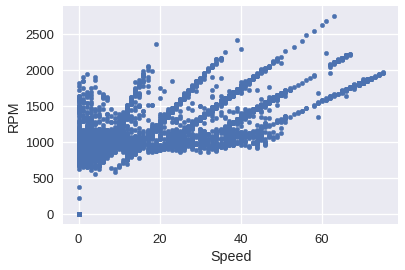

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
%matplotlib inline

df.plot(kind="scatter", y = "RPM", x = "Speed")

To unclutter the graphic a little bit I'll remove datapoints that are not informative - such as when the car is not in movement (or very low movement).

In [10]:
# I'll use 5km/h as the threshold for movement to unclutter the analysis downstream.
df = df[df['Speed']>5]

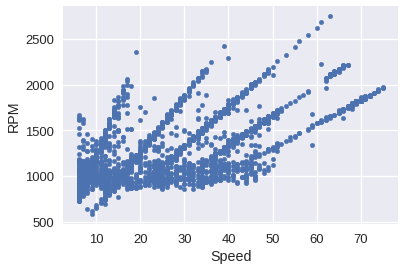

In [11]:
df.plot(kind="scatter", y = "RPM", x = "Speed")                                         

- There are clearly 5 linear associations between RPM and Speed variables, which can be understood as the 5 different transmission gears. 
- The higher the gear, lower the slope - in this case, torque. The first gear has higher torque but slower velocity than the second gear and so on.

- Most datapoints around RPM 1000(±250) are probably the result of gear shifts. 
- It appears that I stretch the third gear the most 

### Machine Learning algorithm to predict gears from RPM and Speed.

Since it's easy to visually identify 5 linear associations I will just manually label some datapoints to train the ML model. Also, linear regression will probably work fine here, as each gear is a result of a linear association between RPM and Speed and have clear boundaries between each other.

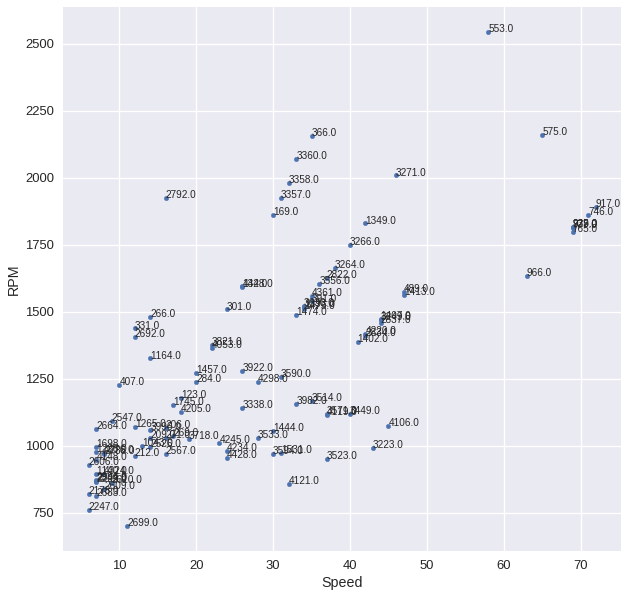

In [12]:
# I ran this code cell a few times to extract various indexes so I can manually label gears.
dfs = df.sample(100)
ax = dfs.plot.scatter(x='Speed',y='RPM', figsize=(10,10))
dfs.reset_index()[['Speed','RPM','index']].apply(lambda x: ax.text(*x),axis=1);

In [13]:
# Manually selected indexes for each gear.

first = [79, 1, 4192, 1885, 3133, 1987, 1125, 1662, 265, 4004, 2512, 411, 2513, 265, 113, 410, 3617, 1178, 996]
second = [175, 180, 153, 3413, 1472, 3799, 3153, 3800, 420, 4171, 1905, 337, 284, 1458, 2796, 3626, 274, 1680, 2566, 3789, 1039, 122, 1912, 3824, 2807, 2798, 338, 82, 3799]
third = [100, 1445, 3953, 3270, 538, 3699, 555, 554, 3339, 3733, 3417, 3630, 4362, 555, 549, 4403, 385, 2821, 856, 100, 99, 1910, 3377, 3837, 540, 3691]
fourth = [3279, 1423, 447, 1431,  3685, 3677, 3282, 872, 568, 587, 461, 3172, 860, 599, 3771, 3571, 2881, 4090, 509, 1379, 465, 625, 829, 592, 1441, 3228, 3516, 3777, 3778, 3568, 875, 567, 876]
fifth = [740, 655, 981, 3291, 803, 971, 797, 967, 648, 915, 887, 886, 918, 920, 650, 638, 2852, 3687, 3299, 3213, 695, 3203]

gears = [first, second, third, fourth, fifth]

In [14]:
# Define a train dataset, dft.
dft = df.copy()
for i in range(len(gears)):
    for j in range(len(gears[i])):
        dft = dft.set_value(gears[i][j], 'Gear', i+1)

#Drop non-labelled rows in the training dataset.
dft.dropna(inplace=True)

In [15]:
print("Number of manually labelled gears:", len(dft))

Number of manually labeled gears: 124


Lets plot the training dataset to see if it makes any sense. It should capture the variation within each gear.

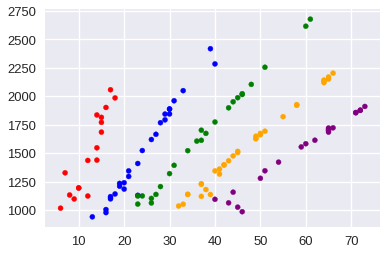

In [16]:
colors = {1:'red', 2:'blue', 3:'green', 4:'orange', 5:'purple'}

fig, ax = plt.subplots()
ax.scatter(dft['Speed'], dft['RPM'], c=dft['Gear'].apply(lambda x: colors[x]), s=25)
plt.show()

It seems good. I extracted enough variation so that the boundary seems to be well defined between each gear.

Logistic regression is the bread and butter of machine learning and it really seems adequate for this context. I'll use scikit-learn library for this.

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [18]:
X, y = dft[['Speed', 'RPM']], dft.Gear

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

I'll do an extensive gridsearch on the optimal C parameter. Logistic regression isn't resource hungry so it should run pretty quick, even with such an extensive gridsearch.

In [20]:
param_grid = {'C': np.arange(0.001, 1, 0.001)}

clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1, 
                                          dual=False, fit_intercept=True,
                                          penalty='l2', tol=0.0001),
             param_grid={'C': np.arange(0.001, 1, 0.001)})

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.001,  0.002, ...,  0.998,  0.999])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
clf.best_estimator_

LogisticRegression(C=0.030000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [22]:
clf.score(X_test, y_test)

1.0

100% accuracy is much likely result of overfitting, but in this case it doesn't really matter: I have very few test data points that are well spacially defined. I'm sure there are some mislabelled points, but they're probably just a few outliers.

Lets now use the model to predict gears from Speed and RPM values in the original dataset.

In [23]:
df['predGear'] = clf.predict(df[["Speed", "RPM"]])

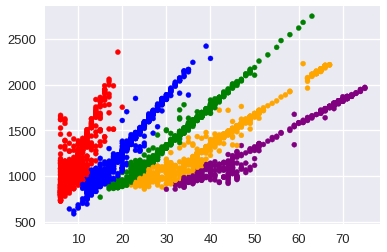

In [24]:
fig, ax = plt.subplots()
ax.scatter(df['Speed'], df['RPM'], c=df['predGear'].apply(lambda x: colors[x]), s=25)
plt.show()

The result is pretty good. Logistic regression worked well here. Having a predicted gear column now enables me to do some more specific analysis.

### Analysis

#### How do all the variables correlate?

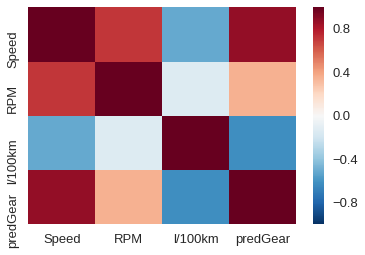

In [25]:
sns.heatmap(df.corr())

- There is a high negative correlation between instant consumption (l/100km) and used gear. - predGear and Speed are highly and positively correlated, which also explains the negative, albeit low, correlation between instant consumption and Speed.

In [26]:
# Variables mean grouped by gear.
df.predGear = df.predGear.astype('int')
df.groupby('predGear').mean()

,Speed,RPM,l/100km
predGear,,,
1,8.933793,1093.304828,23.356506
2,20.321145,1286.163752,13.139480
3,33.291667,1476.500000,9.279713
4,41.972569,1411.841646,5.834024
5,56.784355,1477.035941,3.909805


In [27]:
# Standard deviation grouped by gear.
df.groupby('predGear').std()

,Speed,RPM,l/100km
predGear,,,
1,2.822762,273.362397,16.368001
2,5.980479,347.574452,5.067378
3,7.888154,332.201746,3.084290
4,10.470778,332.088844,2.012506
5,13.816442,368.716693,1.317441


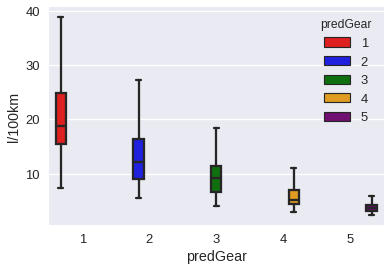

In [28]:
sns.boxplot(data = df, x="predGear", y="l/100km", hue='predGear', sym="", palette=colors)

#### Whats the distribution of instant fuel consumption for each gear?

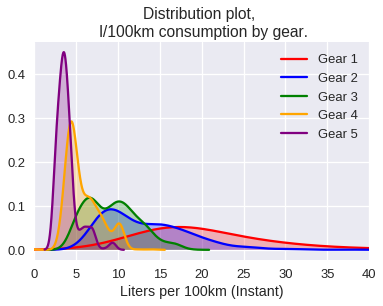

In [29]:
for name, group in df.dropna().groupby('predGear'):
    name = str(int(name))
    sns.kdeplot(group['l/100km'], 
                gridsize=500, 
                label="Gear "+name,
                shade=True,
                color=colors[int(name)]).set(xlim=[0,40], 
                                             title="Distribution plot, \n l/100km consumption by gear.",
                                             xlabel="Liters per 100km (Instant)")

The higher the gear, lesser the consumption (and also lesser variation of instant consumption).

#### Whats the usage proportion of each gear?

In [30]:
df.predGear.value_counts() / np.sum(df.predGear.value_counts()) * 100

4    24.654165
1    22.287120
2    19.335998
3    19.182293
5    14.540424
Name: predGear, dtype: float64

From this proportion I can deduce it was mainly an urban drive - I used the first gear way too much, which probably means I drived in a start-and-stop traffic context. This means the mean consumpt for this trip was probably really high.

In [66]:
df['l/100km'].describe()['50%']

8.8808670000000003

Yep, 8.9 median... that's awful.  

#### How many gear shifts were recorded during this trip? 

In [31]:
# I have to compare each predictedGear row value with the previous.
# If the value is != then its considered a gearshift.

df['gearShift'] = df.predGear.shift(1) != df.predGear
df['gearShift'] = df['gearShift'].astype(int)
df[["predGear", "gearShift"]].iloc[4:7]

,predGear,gearShift
80,1,0
81,2,1
82,2,0


In [67]:
print('Number of gearshifts recorded:', sum(df.gearShift))

Number of gearshifts recorded: 279


#### How many of these gearshifts are up and down-shifts?

In [33]:
df['gearUp'] = df.predGear.shift(1) < df.predGear
df['gearUp'] = df['gearUp'].astype(int)

In [34]:
df['gearDown'] = df.predGear.shift(1) > df.predGear
df['gearDown'] = df['gearDown'].astype(int)

In [35]:
upshifts = df[df.gearUp==1]
print('Number of up-shifts:', len(upshifts))

Number of up-shifts: 140


In [36]:
downshifts = df[df.gearDown==1]
print('Number of down-shifts:', len(downshifts))

Number of down-shifts: 138


#### Whats the proportion of upshifts and downshifts per gear?

In [62]:
# The result should be read as (4 -> 3 to 4), (3 -> 2 to 3), so on.
upshifts.predGear.value_counts() / sum(upshifts.predGear.value_counts())

4    0.300000
2    0.271429
3    0.221429
5    0.207143
Name: predGear, dtype: float64

In [63]:
# The result should be read as (4 -> 5 to 4), (3 -> 4 to 3), so on.
downshifts.predGear.value_counts() / sum(downshifts.predGear.value_counts())

3    0.297101
1    0.275362
2    0.231884
4    0.195652
Name: predGear, dtype: float64

#### Mapping gear shifting to the RPM vs Speed scatterplot. 

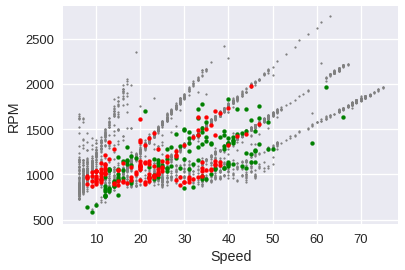

In [37]:
df.plot(kind="scatter", x = "Speed", y = "RPM", color='grey', s=3)            
plt.scatter(data = upshifts, x = 'Speed', y = 'RPM', color="green", s=15)
plt.scatter(data = downshifts, x = 'Speed', y = 'RPM', color="red", s=15)

We shift gears when the RPM are too high or too low to even it. So it was expected to see this sort of cluster of up and downshifts around medium values of RPM (1000-1750). However, if I consider the time-points before gear shift I might see a completely different pattern - up shifts and dow shifts should be clustered separately. 

In [38]:
df['gUp-1'] = df.gearUp.shift(-1)
df['gDown-1'] = df.gearDown.shift(-1)

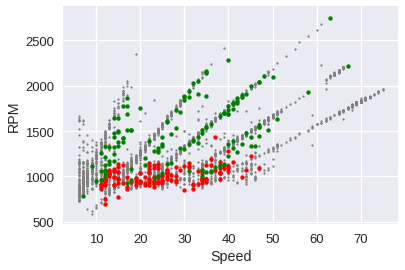

In [39]:
df.plot(kind="scatter", x = "Speed", y = "RPM", color='grey', s=3)

plt.scatter(data= df[df['gDown-1']==1], x = 'Speed', y = 'RPM', color="red", s=15)
plt.scatter(data= df[df['gUp-1']==1], x = 'Speed', y = 'RPM', color="green", s=15)

There it is, a clear pattern between up and down-shifts. Most upshifts occur in higher RPM values while most downshifts in lower RPM values. There is one interesting point I can extract from this:
- There are some sub-1500RPM upshifts that obviously aren't much efficient. I should pay more attention to this. According to the cars manual I should stretch gears until ~2500RPM before up-shifting, which I clearly tend not to do. The plot illustrates my RPM usage per gear. There are alot of sub-optimal gear usage around the 1500-1000 RPM area.

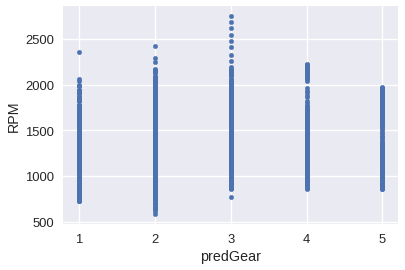

In [40]:
df.plot(kind="scatter", x="predGear", y="RPM")

#### Whats the difference in instant consumption before and after up-shifting a gear? What about  the RPM values?

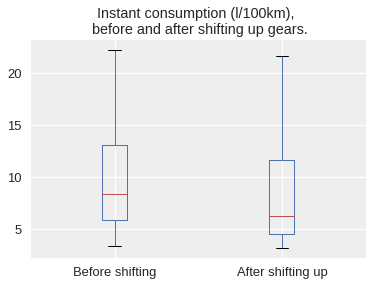

In [65]:
l100km_gup = {"Before shifting": np.array(df[df['gUp-1']==1]['l/100km']), 
              "After shifting up": np.array(upshifts['l/100km'])}

fig = pd.DataFrame(l100km_gup).plot(kind="box", sym = "", 
                                  title="Instant consumption (l/100km), \n before and after shifting up gears.")
fig.invert_xaxis()

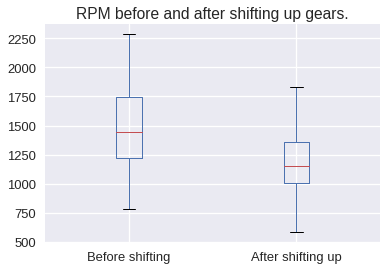

In [42]:
rpm_ba= {"Before shifting": np.array(df[df['gUp-1']==1].RPM), 
         "After shifting up": np.array(upshifts.RPM)}

fig = pd.DataFrame(rpm_ba).plot(kind="box", sym = "",
                                title="RPM before and after shifting up gears.")
fig.invert_xaxis()

#### Annotate gearshifts and gear number on Speed and instant consumption graphics.
Double click to zoom the graphic.

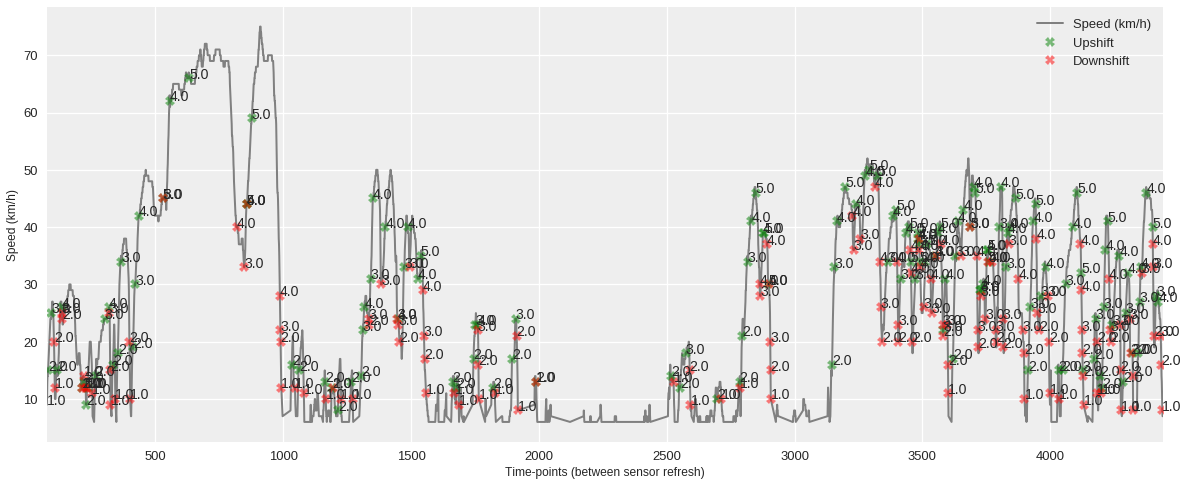

In [47]:
xu = df[df.gearUp==1].index
yu = df[df.gearUp==1]['Speed']

xd = df[df.gearDown==1].index
yd = df[df.gearDown==1]['Speed']

df.Speed.plot(kind="line", figsize=(20,8), color='grey')

plt.plot(xu, yu, 'gX', alpha=0.5)
plt.plot(xd, yd, 'rX', alpha=0.5)
plt.legend(["Speed (km/h)", "Upshift", "Downshift"])
plt.xlabel("Time-points (between sensor refresh)")
plt.ylabel("Speed (km/h)")

anotindex = df[df.gearShift==1].index.tolist()

for i in anotindex:
    plt.annotate(df[df.gearShift==1].ix[i]['predGear'], 
             xy=(i, df.Speed.ix[i]),
             xycoords='data',
             size=14)

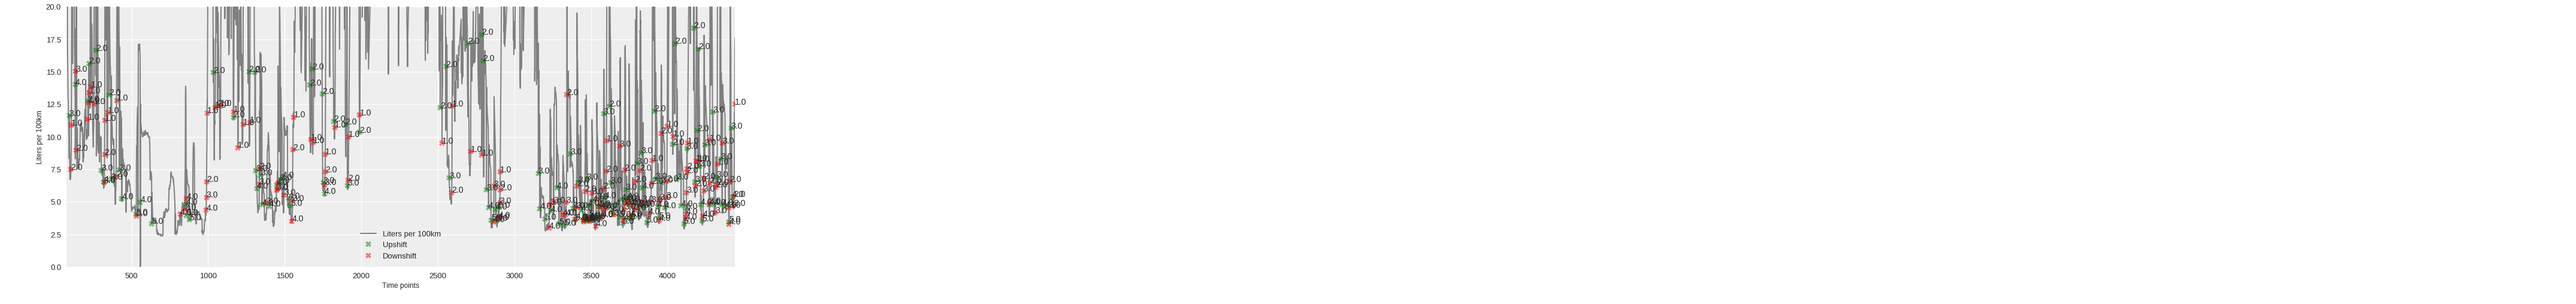

In [46]:
xu = df[df.gearUp==1].index
yu = df[df.gearUp==1]['l/100km']

xd = df[df.gearDown==1].index
yd = df[df.gearDown==1]['l/100km']

df['l/100km'].plot(kind="line", figsize=(20,8), color='grey')

plt.plot(xu, yu, 'gX', alpha=0.5)
plt.plot(xd, yd, 'rX', alpha=0.5)
plt.legend(["Liters per 100km", "Upshift", "Downshift"])
plt.ylabel("Liters per 100km")
plt.xlabel("Time points")
plt.ylim([0, 20])

anotindex = df[df.gearShift==1].index.tolist()

for i in anotindex:
    plt.annotate(df[df.gearShift==1].ix[i]['predGear'], 
             xy=(i, df['l/100km'].ix[i]),
             xycoords='data',
             size=14)

### Conclusion

Analyzing my driving data has taught me something: I can drive even more efficientely in terms of fuel consumption, because this analysis has allowed me to recognize some bad gear shifting habits. I tend to shift too soon. 

I'll log some driving sessions with this in mind to see whether it makes a difference in consumption or not.

In [45]:
# This chunk is only relevant to Jupyter notebook aesthetics.
import json
from pylab import rcParams
s = json.load( open("/home/hypathia/bmh_matplotlibrc.json") )  #edit path to json file
rcParams.update(s)

from IPython.core.display import HTML
def css_styling():
    styles = open("/home/hypathia/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()